# Project 1 -- Jayden Kruse -- Formula One

#### The goal of this project is to take information from a Formula One race weekend, and convert it into visible data using graphs and charts. I'm using OpenF1 as an API endpoint (Item 2) for the project. Even though they have a feature of grabbing real-time data from a race weekend, it does cost some money to get this live feed. I will be using free information from a previous Formula One race weekend. More specificly, I'll be using information from the 2025 Hungarian Grand Prix that happened from August 1st - 3rd. The goal from this project is to compare the race strategy between Oscar Piastri and Lando Norris. I.e., we will look at each drivers stints, gap to leader, and lap times.

In [2]:
# Import all the libraries I will need for this
import requests # Library for making the API request
from urllib.request import urlopen # Another library for making requests
import json # OpenF1 uses this to load the data
import pandas as pd
import numpy as np # Just incase
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# I first need to understand where the information I need is stored
# OpenF1 uses Session Keys to pinpoint data

# This can be a reusable function to look for different GP's beyond the 2025 Hungarian GP
# I might use this again in a future project
def get_session_df(country: str, year: int):
    url = f"https://api.openf1.org/v1/sessions?country_name={country}&year={year}"
    response = urlopen(url)
    data = json.loads(response.read().decode('utf-8'))
    return pd.DataFrame(data)

# I want to use the 2025 Hungarian GP for the project, so this will grab the session data for it
df_sessions = get_session_df("Hungary", 2025)

# This will get the session key for the race so I can use the specific session for my data
race_key = df_sessions.loc[df_sessions["session_name"] == "Race", "session_key"].iloc[0]
print(f"Hungary 2025 race session key: {race_key}")

Hungary 2025 race session key: 9928


In [4]:
# Now that I know the session key, I will use it to gather the information I need from the API

# Session key
session_key = 9928

# Driver numbers
norris = 4
piastri = 81

# The following datasets will be used to compare laptimes throughout the race

# Download lap data for Lando Norris
laps_norris = pd.DataFrame(requests.get(
    f"https://api.openf1.org/v1/laps?session_key={session_key}&driver_number={norris}"
).json())

# Download lap data for Oscar Piastri
laps_piastri = pd.DataFrame(requests.get(
    f"https://api.openf1.org/v1/laps?session_key={session_key}&driver_number={piastri}"
).json())

# Download stint data
# This will allow me to use lap and tire data
stints_norris = pd.DataFrame(requests.get(
    f"https://api.openf1.org/v1/stints?session_key={session_key}&driver_number={norris}"
).json())

stints_piastri = pd.DataFrame(requests.get(
    f"https://api.openf1.org/v1/stints?session_key={session_key}&driver_number={piastri}"
).json())

# Print out the columns available in the laps and stints data frames
print(laps_norris.columns.tolist())
print(stints_piastri.columns.tolist())

['meeting_key', 'session_key', 'driver_number', 'lap_number', 'date_start', 'duration_sector_1', 'duration_sector_2', 'duration_sector_3', 'i1_speed', 'i2_speed', 'is_pit_out_lap', 'lap_duration', 'segments_sector_1', 'segments_sector_2', 'segments_sector_3', 'st_speed']
['meeting_key', 'session_key', 'stint_number', 'driver_number', 'lap_start', 'lap_end', 'compound', 'tyre_age_at_start']


In [5]:
# Print out some of the data for the stint data
print("Norris Stints:")
print(stints_norris)
print("Piastri Stints:")
print(stints_piastri)

Norris Stints:
   meeting_key  session_key  stint_number  driver_number  lap_start  lap_end  \
0         1266         9928             1              4          1       31   
1         1266         9928             2              4         32       70   

  compound  tyre_age_at_start  
0   MEDIUM                  0  
1     HARD                  0  
Piastri Stints:
   meeting_key  session_key  stint_number  driver_number  lap_start  lap_end  \
0         1266         9928             1             81          1       18   
1         1266         9928             2             81         19       45   
2         1266         9928             3             81         46       70   

  compound  tyre_age_at_start  
0   MEDIUM                  0  
1     HARD                  1  
2     HARD                  0  


In [6]:
# Print out some of the lap data
# There is a lot of information in these dataframes, so I'll print the head for certain items in the next block
print("Norris Lap Data:")
print(laps_norris.head())
print("Piastri Lap Data:")
print(laps_piastri.head())

Norris Lap Data:
   meeting_key  session_key  driver_number  lap_number  \
0         1266         9928              4           1   
1         1266         9928              4           2   
2         1266         9928              4           3   
3         1266         9928              4           4   
4         1266         9928              4           5   

                         date_start  duration_sector_1  duration_sector_2  \
0                              None                NaN             31.396   
1  2025-08-03T13:04:36.642000+00:00             30.209             30.346   
2  2025-08-03T13:06:00.525000+00:00             29.792             30.097   
3  2025-08-03T13:07:23.815000+00:00             30.125             29.665   
4  2025-08-03T13:08:46.745000+00:00             29.930             29.672   

   duration_sector_3  i1_speed  i2_speed  is_pit_out_lap  lap_duration  \
0             23.329     248.0       236           False           NaN   
1             23.409   

In [7]:
# I'll print some of the important data I'll be using
print("Norris Lap Data:")
print(laps_norris['lap_number'].head(), laps_norris['lap_duration'].head())
print("Piastri Lap Data:")
print(laps_piastri['lap_number'].head(), laps_piastri['lap_duration'].head())

Norris Lap Data:
0    1
1    2
2    3
3    4
4    5
Name: lap_number, dtype: int64 0       NaN
1    83.964
2    83.223
3    82.877
4    82.639
Name: lap_duration, dtype: float64
Piastri Lap Data:
0    1
1    2
2    3
3    4
4    5
Name: lap_number, dtype: int64 0       NaN
1    83.242
2    83.102
3    82.757
4    82.652
Name: lap_duration, dtype: float64


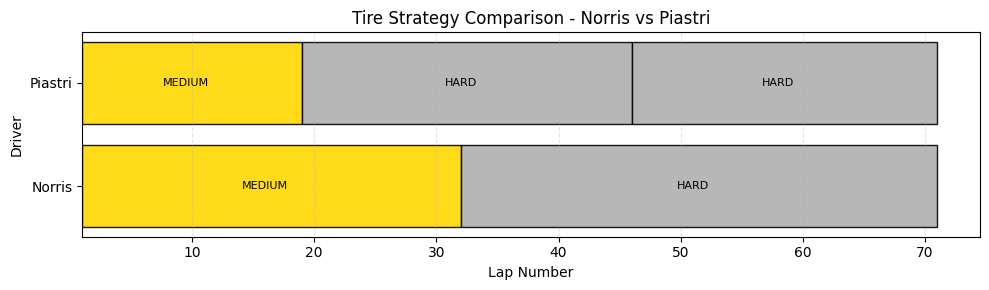

In [8]:
# Since I already have the data needed from the API, all I need to do is plot it
# First, we will plot the stints of each driver

# I'm going to make a dictionary for colors of tire compounds
compound_colors = {
    'SOFT': '#FF4D4D',
    'MEDIUM': '#FFD700',
    'HARD': '#B0B0B0'
}

# I'll combine the driver stints into a single dataframe for convenience
stints_norris['driver'] = 'Norris'
stints_piastri['driver'] = 'Piastri'
stints_all = pd.concat([stints_norris, stints_piastri], ignore_index=True)

# Now I need to set up the figure
plt.figure(figsize=(10,3))

# The y-axis will be the different drivers
drivers = ['Norris', 'Piastri']

# This next part is pretty complex, and I needed some help from chatgpt to get it setup
# Pretty much what it does is graph each bar needed for each driver
# The for loop will loop through each driver
for i, driver in enumerate(drivers):
    # This will grab the driver of the index
    driver_stints = stints_all[stints_all['driver'] == driver]
    # This will plot each drivers horizontal bar
    for _, row in driver_stints.iterrows():
        # Plot a Horizontal Bar Chart
        plt.barh(
            y=i,
            # The width of each stints box
            width=row['lap_end'] - row['lap_start'] + 1,
            # This will move the box to the correct position to the left
            # So stint 1 will start on lap 1 or 'lap_start'
            left=row['lap_start'],
            # This will get the color of the compound of tire for the stint
            color=compound_colors.get(row['compound'], 'gray'),
            # It's nice to have a border to outline where a stint ends and starts
            edgecolor='black',
            # Transparency
            alpha=0.9
        )
        # This will add the name of the compound to the section of bar
        # It takes the average lap number to find the middle
        mid_lap = (row['lap_start'] + row['lap_end']) / 2
        # Plots the text of the compound
        plt.text(mid_lap, i, row['compound'], ha='center', va='center', fontsize=8, color='black')

# Calculates how many y-values there will be
plt.yticks(range(len(drivers)), drivers)
# X-axis label
plt.xlabel('Lap Number')
# Y-axis label
plt.ylabel('Driver')
# Chart title
plt.title('Tire Strategy Comparison - Norris vs Piastri')
# This will add a grid for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

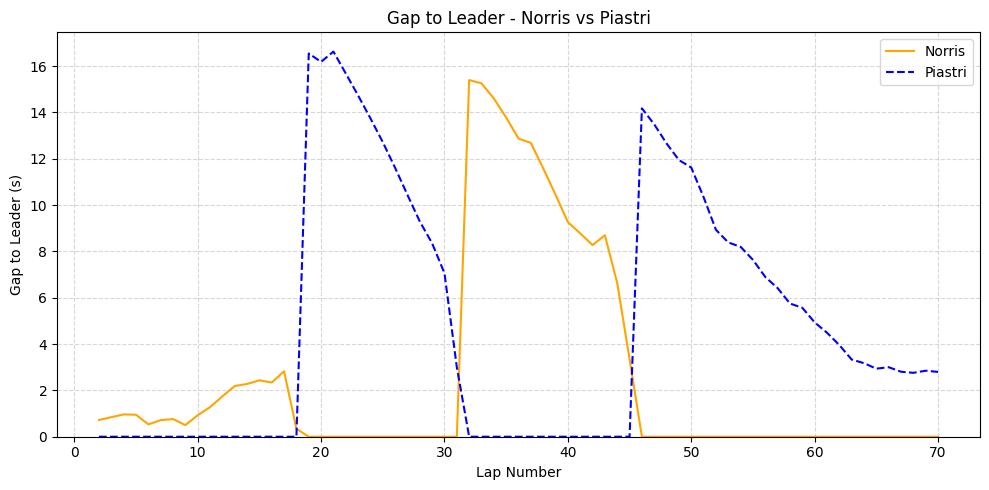

In [9]:
# This will calculate the total time for each drivers race
laps_norris['cum_time'] = laps_norris['lap_duration'].cumsum()
laps_piastri['cum_time'] = laps_piastri['lap_duration'].cumsum()

# This will merge the dataframes together by lap number
intervals = laps_norris[['lap_number', 'cum_time']].merge(
    laps_piastri[['lap_number', 'cum_time']],
    on='lap_number',
    suffixes=('_norris', '_piastri')
)

# Now I need to calculate each drivers gap to the leader
intervals['leader_time'] = intervals[['cum_time_norris', 'cum_time_piastri']].min(axis=1)
intervals['gap_norris'] = intervals['cum_time_norris'] - intervals['leader_time']
intervals['gap_piastri'] = intervals['cum_time_piastri'] - intervals['leader_time']

# Now that I have the gap to leader times, I can plot them
plt.figure(figsize=(10,5))
# Plot Norris' intervals
plt.plot(intervals['lap_number'], intervals['gap_norris'], label='Norris', color='orange')
# Plot Piastri's intervals
plt.plot(intervals['lap_number'], intervals['gap_piastri'], label='Piastri', color='blue', linestyle='--')
# X-axis label
plt.xlabel('Lap Number')
# Y-axis label
plt.ylabel('Gap to Leader (s)')
# Chart title
plt.title('Gap to Leader - Norris vs Piastri')
# Add a legend to understand drivers line color
plt.legend()
# Add a grid to help visualization
plt.grid(True, linestyle='--', alpha=0.5)
# This will limit the y-axis to only go down to 0
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Lap Time Comparison - Norris vs Piastri'}, xlabel='Lap Number', ylabel='Lap Time'>

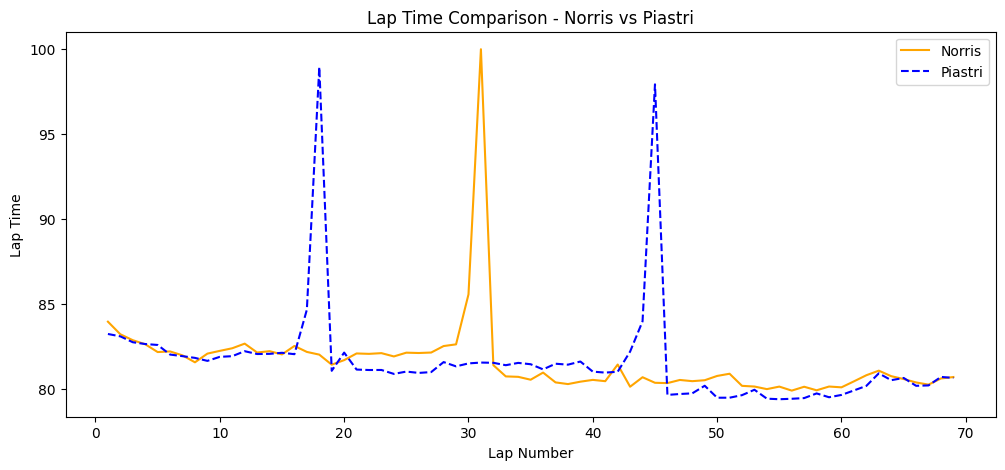

In [10]:
# Now that we have taken a look at the differences in stint strategies and gaps to the leader,
# we can take a look at each drivers individual lap time
# I'll plot both charts in this block to make it visibly easier to understand
laps_norris['lap_duration'].plot(kind='line', figsize=(12,5), x=laps_norris['lap_number'], xlabel="Lap Number", ylabel="Lap Time",
                                 color='orange', legend=True, label="Norris", title="Lap Time Comparison - Norris vs Piastri")
laps_piastri['lap_duration'].plot(kind='line', x=laps_piastri['lap_number'], xlabel="Lap Number", ylabel="Lap Time",
                                 color='blue', linestyle='--', legend=True, label="Piastri")
# This will plot the x-axis as the lap number, y-axis as the lap duration, and include things like a legend to specify which
# line is for which driver

# Conclusion

#### These graphs show important data that show the difference in strategy between Lando Norris and Oscar Piastri during the 2025 Hungarian Grand Prix. A race that started in Piastris way as he lead from the start, but due to differing strategy, ultimately allowed Norris to seal the victory. The first graph has shown the difference between tire stints as Lando did a one stop from mediums to hards, and Oscar did a two stop from mediums to hards to hards once more. The second graph illistrate the gap to the leader of the race which switches between Oscar and Lando due to their differing strategies. The third and final graph shows the difference in lap times between the two drivers throughout the duration of the race.